In [1]:
!pip install zstandard pandas jsonlines


In [23]:
import zstandard
import os
import json
import pandas as pd
from datetime import datetime
import logging

# Set up logging
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)

            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]

        reader.close()


if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/Northwestern_submissions.zst'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    bad_lines = 0

    # Store processed JSON objects in a list
    data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Parse JSON line
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))  # Add readable timestamp
            data.append(obj)  # Append to the list
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"Processed {file_lines:,} lines, {bad_lines:,} bad lines. {file_bytes_processed / file_size * 100:.2f}% complete.")

    log.info(f"Complete: {file_lines:,} lines processed with {bad_lines:,} bad lines.")

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Specify the columns to keep
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author", 
        "created_utc", "id", "media", "num_comments", 
        "subreddit", "created_datetime"
    ]

    # Filter the DataFrame to retain only these columns
    df = df[columns_to_keep]

    # Display first few rows
    # df.head()

    # Save to a CSV file for further analysis
    # df.to_csv('reddit_data.csv', index=False)


Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.


In [24]:
df.head()

,title,selftext,score,archived,author,created_utc,id,media,num_comments,subreddit,created_datetime
0,Whatever happened to nuonlinebooks?,,2,True,valtchanov,1231134298,7nf56,None,3,Northwestern,2009-01-05 05:44:58
1,Prosecutor Turns On Crusading Journalism School,,4,True,dustcircle,1263261289,aofy8,None,0,Northwestern,2010-01-12 01:54:49
2,Is this subreddit completely dead?,[removed],3,True,[deleted],1284696944,df1hz,None,6,Northwestern,2010-09-17 04:15:44
3,Resurrecting...,[deleted],1,True,[deleted],1286743871,dpff1,None,0,Northwestern,2010-10-10 20:51:11
4,Resurrecting...,,12,True,verymuchn0,1286744557,dpfj8,None,5,Northwestern,2010-10-10 21:02:37


In [25]:
# Display basic information about the DataFrame
print("Basic DataFrame Information:")
print(df.info())

# Number of rows and columns
print("\nShape of DataFrame (rows, columns):")
print(df.shape)

# Count of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())


Basic DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15175 entries, 0 to 15174
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             15175 non-null  object        
 1   selftext          15175 non-null  object        
 2   score             15175 non-null  int64         
 3   archived          14087 non-null  object        
 4   author            15175 non-null  object        
 5   created_utc       15175 non-null  object        
 6   id                15175 non-null  object        
 7   media             232 non-null    object        
 8   num_comments      15175 non-null  int64         
 9   subreddit         15175 non-null  object        
 10  created_datetime  15175 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.3+ MB
None

Shape of DataFrame (rows, columns):
(15175, 11)

Missing values per column:
title    

In [26]:
# First 5 values for each column
print("\nFirst 5 values for each column:")
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].head(20).to_list())


First 5 values for each column:

Column: title
['Whatever happened to nuonlinebooks?', 'Prosecutor Turns On Crusading Journalism School', 'Is this subreddit completely dead?', 'Resurrecting...', 'Resurrecting...', 'Northwestern Professor awarded Nobel Economics Prize ', 'TIL why the front doors of tech are so difficult to open', 'NU makes the headlines...ಠ_ಠ', 'NU Pranks', 'Evanston, IL: Scavenge Hunt. Any interest? (Crossposted by request). ', 'I am moving to Evanston for work at Northwestern. Does anyone have advice where or where not to live.', 'Free Food Watch', 'Any NU redditors that live in Bobb-McCulloch?', 'Best WCAS distros?', 'Any NU redditors attend the Chicago or DC Rallies to Restore Sanity and/or Fear?', 'Thanksgiving break', 'DAE...', 'Seen in the windows of Pancoe...', 'Best building to be in for the highest probability of survival in a medieval era style siege', 'Looking for a WCAS humanities distro for next quarter']

Column: selftext
['', '', '[removed]', '[deleted]

/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/3034475546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_posts['year'] = filtered_posts['created_datetime'].dt.year


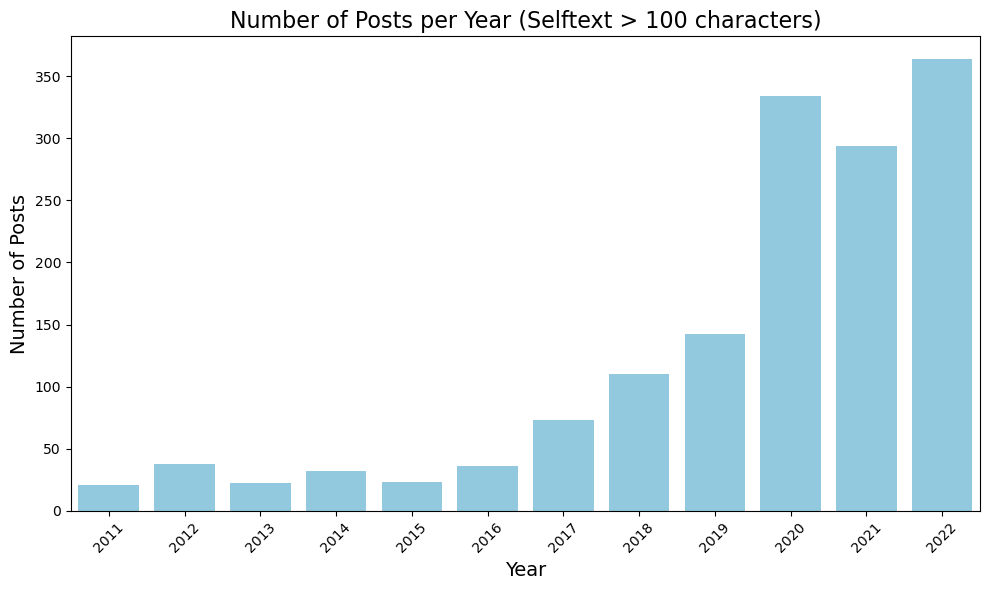

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter posts where 'selftext' is more than 100 characters
filtered_posts = df[df['selftext'].str.len() > 500]

# Step 2: Extract the year from the 'created_datetime' column
filtered_posts['year'] = filtered_posts['created_datetime'].dt.year

# Step 3: Count the number of posts per year
posts_per_year = filtered_posts['year'].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')

# Adding labels and title
plt.title('Number of Posts per Year (Selftext > 100 characters)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
print(filtered_posts["selftext"].head(5).to_list())

["You probably got this email from the Dean of Students, but if you skipped over it...\n\nDear Students:\n\nThe City of Evanston today announced that, it does not plan to enforce more strictly a city ordinance prohibiting more than three unrelated persons living in the same apartment or house. The city has no plans to evict students from rental properties. The announcement came after Northwestern University administrators met with city officials about this planned action.\n\nWe appreciate the responsiveness of Evanston officials to the concerns raised by Northwestern students and administrators. At the same time, the University will oppose any efforts that target our students selectively using this ordinance. Doing so would be a disservice to our students, the University and the entire Evanston community.\n\nWe understand that the City was responding to complaints from other Evanston residents living near campus about issues related to noise, trash and unruly behavior and in an effort 

# Read Data with Comments

In [41]:
if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/Northwestern_comments.zst'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    bad_lines = 0

    # Store processed JSON objects in a list
    data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Parse JSON line
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))  # Add readable timestamp
            data.append(obj)  # Append to the list
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"Processed {file_lines:,} lines, {bad_lines:,} bad lines. {file_bytes_processed / file_size * 100:.2f}% complete.")

    log.info(f"Complete: {file_lines:,} lines processed with {bad_lines:,} bad lines.")

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Specify the columns to keep

    # Filter the DataFrame to retain only these columns
    #df = df[columns_to_keep]

Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.


In [42]:
# Display basic information about the DataFrame
print("Basic DataFrame Information:")
print(df.info())

# Number of rows and columns
print("\nShape of DataFrame (rows, columns):")
print(df.shape)

# Count of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

Basic DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76411 entries, 0 to 76410
Data columns (total 77 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   score                            76411 non-null  int64         
 1   downs                            7538 non-null   float64       
 2   ups                              8781 non-null   float64       
 3   author                           76411 non-null  object        
 4   gilded                           76411 non-null  int64         
 5   created_utc                      76411 non-null  object        
 6   archived                         44652 non-null  object        
 7   edited                           76411 non-null  object        
 8   id                               76411 non-null  object        
 9   distinguished                    235 non-null    object        
 10  body                         

In [45]:
# Specify the columns to keep
columns_to_keep = [
    "score", "downs", "ups", "body", "author", 
    "created_utc", "id", "subreddit_id", 
    "parent_id", "created_datetime"
]

# Filter the DataFrame to retain only these columns
df = df[columns_to_keep]

In [46]:
df.head()

,score,downs,ups,body,author,created_utc,id,subreddit_id,parent_id,created_datetime
0,0,0.0,0.0,I've used it multiple times to find out what b...,valtchanov,1231134421,ae8q,t5_2qptt,t3_7nf56,2009-01-05 05:47:01
1,2,0.0,2.0,Don't they just get their info from the Norris...,dangson,1231136106,aepr,t5_2qptt,t1_ae8q,2009-01-05 06:15:06
2,1,0.0,1.0,Wow. I never knew that.\n\nI just checked and ...,valtchanov,1231197397,awk2,t5_2qptt,t1_aepr,2009-01-05 23:16:37
3,1,0.0,1.0,Yes.,TK-422,1285830973,c10y8hr,t5_2qptt,t3_df1hz,2010-09-30 07:16:13
4,1,0.0,1.0,definitely.,sirdrault,1286167637,c11b6p0,t5_2qptt,t3_df1hz,2010-10-04 04:47:17


/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/3415831261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_posts['year'] = filtered_posts['created_datetime'].dt.year


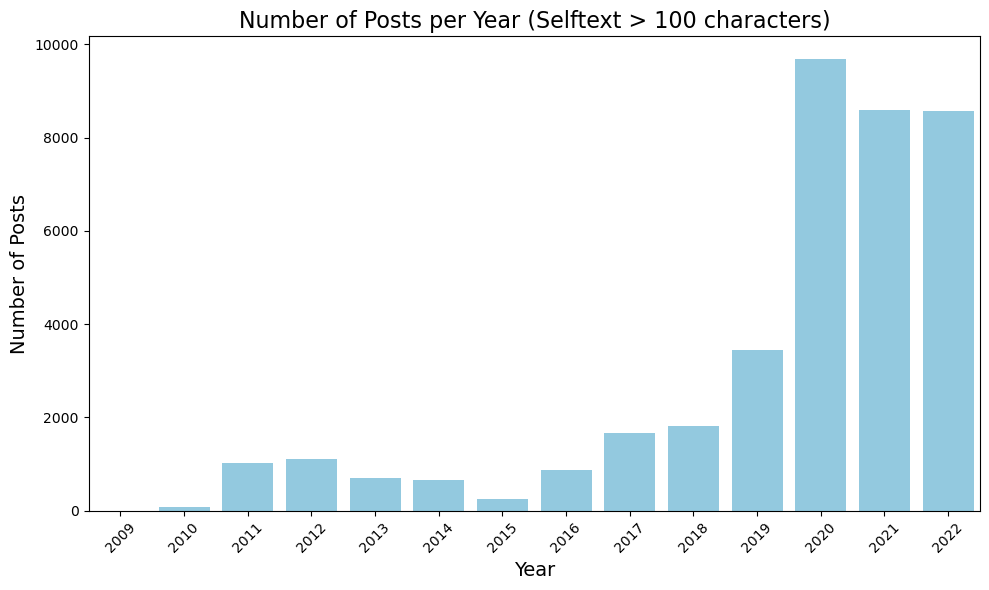

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter posts where 'selftext' is more than 100 characters
filtered_posts = df[df['body'].str.len() > 100]

# Step 2: Extract the year from the 'created_datetime' column
filtered_posts['year'] = filtered_posts['created_datetime'].dt.year

# Step 3: Count the number of posts per year
posts_per_year = filtered_posts['year'].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')

# Adding labels and title
plt.title('Number of Posts per Year (Selftext > 100 characters)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()